<a href="https://colab.research.google.com/github/gabriel-f-santos/dattathons/blob/main/Copy_of_datathons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fluxo Atividades:
- pre processamento e análise exploratória 
- modelagem 
- análise de métricas de assertividade da previsão 
- desenhar o Dashboard

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install dataprep
from dataprep.eda import create_report

In [ ]:
distribuidoras = pd.read_excel("https://datathonsteam9.s3.amazonaws.com/Datathons_pec_carga/Distribuidoras_Area_Atuacao.xlsx")

In [ ]:
municipios = pd.read_csv("https://datathonsteam9.s3.amazonaws.com/Datathons_pec_carga/Municipios_SP.csv")

In [ ]:
carga = pd.read_csv("https://datathonsteam9.s3.amazonaws.com/Datathons_pec_carga/seriesCargaSP.csv", sep=';')

In [ ]:
inmet = pd.read_csv("https://datathonsteam9.s3.amazonaws.com/Datathons_pec_carga/inmet.csv", sep=';')

In [ ]:
distribuidoras.head()
# pre processamento: merge com os dados 'latitude' e 'longitude' do dataframe 'municipios'.
# dúvidas: como cruzar os dados de temperatura das estações com cada município?
# dados faltantes no arquivo inmet: interpolar?

In [ ]:
print(list(municipios.columns))
colunas_municipios = ['codigo_ibge', 'capital', 'siafi_id', 'ddd']
municipios.drop(columns = colunas_municipios, inplace=True)

municipios.head()

['codigo_ibge', 'nome', 'latitude', 'longitude', 'capital', 'codigo_uf', 'siafi_id', 'ddd', 'fuso_horario']


,nome,latitude,longitude,codigo_uf,fuso_horario
0,Abadia de Goiás,-16.75730,-49.4412,52,America/Sao_Paulo
1,Abadia dos Dourados,-18.48310,-47.3916,31,America/Sao_Paulo
2,Abadiânia,-16.19700,-48.7057,52,America/Sao_Paulo
3,Abaeté,-19.15510,-45.4444,31,America/Sao_Paulo
4,Abaetetuba,-1.72183,-48.8788,15,America/Sao_Paulo


In [ ]:
carga['din_ocorrencia'] = pd.to_datetime(carga['din_ocorrencia'])
carga.head()

,nom_seriehistorica,din_ocorrencia,val_itemserieoriginal
0,SP-ENERGISA SSE-SP,2018-01-01 00:00:00,"368,0490112"
1,SP-ENERGISA SSE-SP,2018-01-01 01:00:00,"360,5190125"
2,SP-ENERGISA SSE-SP,2018-01-01 02:00:00,"350,4570007"
3,SP-ENERGISA SSE-SP,2018-01-01 03:00:00,"335,697998"
4,SP-ENERGISA SSE-SP,2018-01-01 04:00:00,"323,0639954"


In [ ]:
def clean_carga(df):
  dfs_parciais = {}
  distribuidoras = carga['nom_seriehistorica'].unique()
  for distribuidora in distribuidoras:
    filtro_distribuidora = df['nom_seriehistorica'] == distribuidora
    _df = df[filtro_distribuidora].copy()
    max_date = _df['din_ocorrencia'].max()
    min_date = _df['din_ocorrencia'].min()
    idx = pd.date_range(min_date, max_date, freq = '1H')
    _df.index = pd.DatetimeIndex(_df['din_ocorrencia'])
    _df.drop('din_ocorrencia', axis=1, inplace=True)

    mask = _df.index.duplicated()
    _df = _df.loc[~mask]
    _df = (_df.resample('1H')
            .bfill()
            .ffill()
          )
    
    dfs_parciais[distribuidora] = _df
  return dfs_parciais
dict_distribuidoras = clean_carga(carga)

In [ ]:
def concatenate_dfs(dict_carga):
  frames = []
  distribuidoras = list(dict_carga.keys())
  for distribuidora in distribuidoras:
    _df = dict_carga[distribuidora]
    frames.append(_df)

  result = pd.concat(frames)
  return result

carga_cleaned = concatenate_dfs(dict_distribuidoras)

In [ ]:
carga_cleaned

In [ ]:
carga = carga_cleaned.copy()
carga.reset_index(drop=False, inplace=True)
carga.head()

,din_ocorrencia,nom_seriehistorica,val_itemserieoriginal
0,2018-01-01 00:00:00,SP-ENERGISA SSE-SP,"368,0490112"
1,2018-01-01 01:00:00,SP-ENERGISA SSE-SP,"360,5190125"
2,2018-01-01 02:00:00,SP-ENERGISA SSE-SP,"350,4570007"
3,2018-01-01 03:00:00,SP-ENERGISA SSE-SP,"335,697998"
4,2018-01-01 04:00:00,SP-ENERGISA SSE-SP,"323,0639954"


In [ ]:
carga['Dates'] = pd.to_datetime(carga['din_ocorrencia']).dt.date
carga['Time'] = pd.to_datetime(carga['din_ocorrencia']).dt.time
# carga.drop(columns = ['din_ocorrencia'], inplace = True)

carga.head()

,din_ocorrencia,nom_seriehistorica,val_itemserieoriginal,Dates,Time
0,2018-01-01 00:00:00,SP-ENERGISA SSE-SP,"368,0490112",2018-01-01,00:00:00
1,2018-01-01 01:00:00,SP-ENERGISA SSE-SP,"360,5190125",2018-01-01,01:00:00
2,2018-01-01 02:00:00,SP-ENERGISA SSE-SP,"350,4570007",2018-01-01,02:00:00
3,2018-01-01 03:00:00,SP-ENERGISA SSE-SP,"335,697998",2018-01-01,03:00:00
4,2018-01-01 04:00:00,SP-ENERGISA SSE-SP,"323,0639954",2018-01-01,04:00:00


In [ ]:
print(list(inmet.columns))
colunas_inmet = ['nom_varmeteo', 'din_inclusaodl']
inmet.drop(columns = colunas_inmet, inplace=True)
inmet.head()

['id_estacaometeo', 'id_varmeteo', 'nom_varmeteo', 'nom_longo', 'din_medicao', 'din_inclusaodl', 'val_medicao', 'val_altitude', 'val_latitude', 'val_longitude']


,id_estacaometeo,id_varmeteo,nom_longo,din_medicao,val_medicao,val_altitude,val_latitude,val_longitude
0,A701,TEM_MAX,São Paulo - Mirante de Santana,2020-05-23 09:00:00.000,20.6,792.06,-23.496294,-46.620087
1,A705,TEM_MAX,Bauru,2020-05-23 09:00:00.000,19.3,550.00,-22.358051,-49.028877
2,A706,TEM_MAX,Campos do Jordão,2020-05-23 09:00:00.000,18.3,1580.00,-22.750278,-45.603890
3,A707,TEM_MAX,Presidente Prudente,2020-05-23 09:00:00.000,14.5,435.55,-22.119867,-51.408638
4,A708,TEM_MAX,Franca,2020-05-23 09:00:00.000,17.3,1003.00,-20.584444,-47.382500


In [ ]:
inmet.head()

,id_estacaometeo,id_varmeteo,nom_longo,din_medicao,val_medicao,val_altitude,val_latitude,val_longitude
0,A701,TEM_MAX,São Paulo - Mirante de Santana,2020-05-23 09:00:00.000,20.6,792.06,-23.496294,-46.620087
1,A705,TEM_MAX,Bauru,2020-05-23 09:00:00.000,19.3,550.00,-22.358051,-49.028877
2,A706,TEM_MAX,Campos do Jordão,2020-05-23 09:00:00.000,18.3,1580.00,-22.750278,-45.603890
3,A707,TEM_MAX,Presidente Prudente,2020-05-23 09:00:00.000,14.5,435.55,-22.119867,-51.408638
4,A708,TEM_MAX,Franca,2020-05-23 09:00:00.000,17.3,1003.00,-20.584444,-47.382500


In [ ]:
print(inmet['id_varmeteo'].unique())
filtro = inmet['id_varmeteo'] == 'TEM_INS' 
inmet = inmet[filtro]
inmet['din_medicao'] = pd.to_datetime(inmet['din_medicao'])
print(inmet['id_varmeteo'].unique())

['TEM_MAX' 'TEM_INS' 'TEM_MIN']
['TEM_INS']


In [ ]:
#Checando valores nulos de carga
carga[carga['val_itemserieoriginal'].isnull()]

,din_ocorrencia,nom_seriehistorica,val_itemserieoriginal,Dates,Time


In [ ]:
#Checando valores nulos de inmet
inmet[inmet['val_medicao'].isnull()]

,id_estacaometeo,id_varmeteo,nom_longo,din_medicao,val_medicao,val_altitude,val_latitude,val_longitude
105,A735,TEM_INS,Jose Bonifácio,2020-06-29 18:00:00,NaN,405.0,-21.085556,-49.920277
106,A736,TEM_INS,Ariranha,2020-06-29 18:00:00,NaN,525.0,-21.133055,-48.840557
108,A738,TEM_INS,Casa Branca,2020-06-29 18:00:00,NaN,734.0,-21.780556,-47.075280
109,A739,TEM_INS,Itapira,2020-06-29 18:00:00,NaN,635.0,-22.415000,-46.805280
111,A741,TEM_INS,Barra Bonita,2020-06-29 18:00:00,NaN,543.0,-22.471111,-48.557500
...,...,...,...,...,...,...,...,...
4939691,A762,TEM_INS,Dracena,2019-08-14 06:00:00,NaN,720.0,-21.457699,-51.552254
4939692,A762,TEM_INS,Dracena,2019-08-14 07:00:00,NaN,720.0,-21.457699,-51.552254
4939693,A762,TEM_INS,Dracena,2019-08-14 08:00:00,NaN,720.0,-21.457699,-51.552254
4939707,A762,TEM_INS,Dracena,2019-08-14 22:00:00,NaN,720.0,-21.457699,-51.552254


In [ ]:
# Convertendo carga para float
carga['val_itemserieoriginal'] = carga['val_itemserieoriginal'].astype('str').apply(lambda x: x.replace(',', '.')).astype(np.float16) 
carga['val_itemserieoriginal'] = carga['val_itemserieoriginal'].astype(np.float16)
carga['val_itemserieoriginal'].fillna(int(carga['val_itemserieoriginal'].median()), inplace=True) 
carga['val_itemserieoriginal'].head()

0    368.00
1    360.50
2    350.50
3    335.75
4    323.00
Name: val_itemserieoriginal, dtype: float16

Tratamento dados Inmet

In [ ]:
estacoes = inmet['id_estacaometeo'].unique()
estacoes = [ i for i in estacoes]
# estacão sme valores
estacoes.remove('A745')

In [ ]:
def clean_inmet(df, estacoes):
  dfs_parciais = {}
  for estacao in estacoes: 
    filtro_estacao = df['id_estacaometeo'] == estacao
    _df = df[filtro_estacao].copy()
    max_date = _df['din_medicao'].max()
    min_date = _df['din_medicao'].min()
    idx = pd.date_range(min_date, max_date, freq = '1H')
    _df.index = pd.DatetimeIndex(_df['din_medicao'])
    _df.drop('din_medicao', axis=1, inplace=True)

    mask = _df.index.duplicated()
    _df = _df.loc[~mask]
    _df = (_df.resample('1H')
            .bfill()
            .ffill()
          )
    
    dfs_parciais[estacao] = _df
  return dfs_parciais
dict_estacoes = clean_inmet(inmet, estacoes)


In [ ]:
def fill_na_estacoes(dict_estacoes, estacoes):
  _dict_estacoes = {}
  for estacao in estacoes:
    _df = dict_estacoes[estacao].copy()
    _df['val_medicao'] = _df['val_medicao'].fillna(int(_df['val_medicao'].mean()))
    _dict_estacoes[estacao] = _df
  return _dict_estacoes

dict_estacoes = fill_na_estacoes(dict_estacoes, estacoes)

In [ ]:
def concatenate_dfs(dict_estacoes):
  frames = []
  for estacao in estacoes:
    _df = dict_estacoes[estacao]
    frames.append(_df)

  result = pd.concat(frames)
  return result

inmet_cleaned = concatenate_dfs(dict_estacoes)

In [ ]:
inmet_cleaned.reset_index(drop=False, inplace=True)
inmet_cleaned.head()

,din_medicao,id_estacaometeo,id_varmeteo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude
0,2018-01-01 00:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,21.1,792.06,-23.483334,-46.616665
1,2018-01-01 01:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.9,792.06,-23.483334,-46.616665
2,2018-01-01 02:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.8,792.06,-23.483334,-46.616665
3,2018-01-01 03:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.6,792.06,-23.483334,-46.616665
4,2018-01-01 04:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.6,792.06,-23.483334,-46.616665


In [ ]:
#Checando valores nulos de inmet
inmet_cleaned[inmet_cleaned['val_medicao'].isnull()]

,din_medicao,id_estacaometeo,id_varmeteo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude


In [ ]:
# inmet_cleaned['Dates'] = pd.to_datetime(inmet_cleaned['din_medicao']).dt.date
# inmet_cleaned['Time'] = pd.to_datetime(inmet_cleaned['din_medicao']).dt.time
# inmet_cleaned.drop(columns = ['din_medicao'], inplace = True)

# inmet_cleaned.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


DataPrep Report
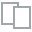
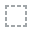
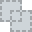
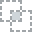
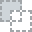
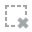
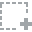
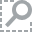
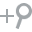
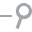
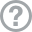
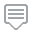
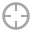
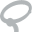
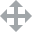
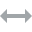
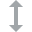
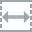
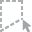
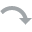
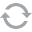
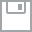
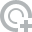
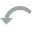
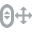
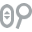
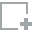
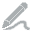
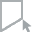
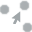
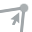
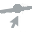

In [ ]:
create_report(inmet_cleaned[filtro])

In [ ]:
municipios. rename(columns = {'nome':'Município'}, inplace = True)  
mergedRes = pd.merge(distribuidoras, municipios, on ='Município', how ="left")

In [ ]:
stations = inmet_cleaned.drop_duplicates(subset=['id_estacaometeo'])  
stations.head()

,din_medicao,id_estacaometeo,id_varmeteo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude
0,2018-01-01,A701,TEM_INS,São Paulo - Mirante de Santana,21.1,792.06,-23.483334,-46.616665
38988,2018-01-01,A705,TEM_INS,Bauru,21.2,666.00,-22.358055,-49.028890
77976,2018-01-01,A706,TEM_INS,Campos do Jordão,15.4,1642.00,-22.750278,-45.603890
116964,2018-01-01,A707,TEM_INS,Presidente Prudente,22.7,435.55,-22.120000,-51.400000
155952,2018-01-01,A708,TEM_INS,Franca,19.5,1026.00,-20.580000,-47.380000


In [ ]:
cidades_estacoes = {}
for estacao in stations['id_estacaometeo'].unique():
  filtro = stations['id_estacaometeo'] == estacao
  cidades_estacoes[stations[ filtro ]['nom_longo'].unique()[0]] = estacao 

In [ ]:
dict_municipios_distribuidora = {}
list_distribuidoras = list(mergedRes['Distribuidora'].unique())
for distribuidora in list_distribuidoras:
  dict_municipios_distribuidora[distribuidora] = mergedRes[mergedRes['Distribuidora'] == distribuidora]['Município'].values

#Associando as estações met. com a região que cada distribuidora atende

In [ ]:
dist_regiao = {}
list_cidades_estacoes = list(cidades_estacoes.keys())
for dist, cidades in dict_municipios_distribuidora.items():
  _list_est = []                              
  for cidade in cidades:
    if cidade in list_cidades_estacoes:
      _list_est.append(cidades_estacoes[cidade])
      dist_regiao[dist] = _list_est
dist_regiao

{'CPFL PAULISTA': ['A736',
  'A741',
  'A741',
  'A748',
  'A705',
  'A764',
  'A708',
  'A737',
  'A739',
  'A753',
  'A727',
  'A763',
  'A726',
  'A711',
  'A711'],
 'CPFL PIRATININGA': ['A713'],
 'CPFL SANTA CRUZ': ['A716'],
 'EDP SP': ['A769', 'A767', 'A767', 'A728'],
 'ELEKTRO': ['A746',
  'A765',
  'A706',
  'A762',
  'A712',
  'A714',
  'A714',
  'A733',
  'A766',
  'A729'],
 'ELETROPAULO': ['A755'],
 'ENERGISA SSE-SP': ['A744', 'A714', 'A714', 'A763', 'A707', 'A718', 'A768']}

In [ ]:
carga.reset_index(drop=False, inplace=True)
carga.head()

,index,din_ocorrencia,nom_seriehistorica,val_itemserieoriginal,Dates,Time
0,0,2018-01-01 00:00:00,SP-ENERGISA SSE-SP,368.00,2018-01-01,00:00:00
1,1,2018-01-01 01:00:00,SP-ENERGISA SSE-SP,360.50,2018-01-01,01:00:00
2,2,2018-01-01 02:00:00,SP-ENERGISA SSE-SP,350.50,2018-01-01,02:00:00
3,3,2018-01-01 03:00:00,SP-ENERGISA SSE-SP,335.75,2018-01-01,03:00:00
4,4,2018-01-01 04:00:00,SP-ENERGISA SSE-SP,323.00,2018-01-01,04:00:00


In [ ]:
inmet_cleaned.head()

,din_medicao,id_estacaometeo,id_varmeteo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude
0,2018-01-01 00:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,21.1,792.06,-23.483334,-46.616665
1,2018-01-01 01:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.9,792.06,-23.483334,-46.616665
2,2018-01-01 02:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.8,792.06,-23.483334,-46.616665
3,2018-01-01 03:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.6,792.06,-23.483334,-46.616665
4,2018-01-01 04:00:00,A701,TEM_INS,São Paulo - Mirante de Santana,20.6,792.06,-23.483334,-46.616665


In [ ]:
carga[carga['nom_seriehistorica'] == 'CPFL PAULISTA']

,index,din_ocorrencia,nom_seriehistorica,val_itemserieoriginal,Dates,Time


In [ ]:
DF_CPFL_PAULISTA.head()

In [ ]:
carga['nom_seriehistorica'] = carga['nom_seriehistorica'].apply(lambda x: x.replace('SP-', ''))
carga['nom_seriehistorica']

0         ENERGISA SSE-SP
1         ENERGISA SSE-SP
2         ENERGISA SSE-SP
3         ENERGISA SSE-SP
4         ENERGISA SSE-SP
               ...       
256915      CPFL PAULISTA
256916      CPFL PAULISTA
256917      CPFL PAULISTA
256918      CPFL PAULISTA
256919      CPFL PAULISTA
Name: nom_seriehistorica, Length: 256920, dtype: object

In [ ]:
dist_regiao['CPFL PAULISTA']

['A736',
 'A741',
 'A741',
 'A748',
 'A705',
 'A764',
 'A708',
 'A737',
 'A739',
 'A753',
 'A727',
 'A763',
 'A726',
 'A711',
 'A711']

In [ ]:
carga.rename(columns = {0:'din_medicao'}, inplace = True)  
carga.head()

,index,din_ocorrencia,nom_seriehistorica,val_itemserieoriginal,Dates,Time
0,0,2018-01-01 00:00:00,ENERGISA SSE-SP,368.00,2018-01-01,00:00:00
1,1,2018-01-01 01:00:00,ENERGISA SSE-SP,360.50,2018-01-01,01:00:00
2,2,2018-01-01 02:00:00,ENERGISA SSE-SP,350.50,2018-01-01,02:00:00
3,3,2018-01-01 03:00:00,ENERGISA SSE-SP,335.75,2018-01-01,03:00:00
4,4,2018-01-01 04:00:00,ENERGISA SSE-SP,323.00,2018-01-01,04:00:00


In [ ]:
DF_CPFL_PAULISTA

In [ ]:
lista_dfs_cpfl_paulista = []
DITRIBUIDORA = 'CPFL PAULISTA'
DF_CPFL_PAULISTA = carga[ carga['nom_seriehistorica'] == DITRIBUIDORA]
DF_CPFL_PAULISTA.rename(columns = {'din_ocorrencia':'din_medicao'}, inplace = True)
for estacao in dist_regiao[DITRIBUIDORA]:
  _df = inmet_cleaned[ inmet_cleaned['id_estacaometeo'] == estacao]
  lista_dfs_cpfl_paulista.append(_df[['val_medicao', 'din_medicao']])

for i in range(len(dist_regiao[DITRIBUIDORA])):
  lista_dfs_cpfl_paulista[i].rename(columns = {'val_medicao':'val_medicao_'+str(i)}, inplace = True)  
  DF_CPFL_PAULISTA = pd.merge(DF_CPFL_PAULISTA, lista_dfs_cpfl_paulista[i], on ='din_medicao', how ="left")

columns = ['val_medicao_'+str(i) for i in range(len(dist_regiao[DITRIBUIDORA]))]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
DF_CPFL_PAULISTA['temperatura'] = DF_CPFL_PAULISTA[columns].mean(axis=1)

In [ ]:
DF_CPFL_PAULISTA.drop(columns=columns, inplace=True)
DF_CPFL_PAULISTA = DF_CPFL_PAULISTA[['Dates',	'Time', 'temperatura', 'val_itemserieoriginal']]
DF_CPFL_PAULISTA.rename(columns = {'val_itemserieoriginal':'carga'}, inplace = True)  
DF_CPFL_PAULISTA.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Dates,Time,temperatura,carga
0,2018-01-01,00:00:00,20.540000,2570.0
1,2018-01-01,01:00:00,20.360000,2516.0
2,2018-01-01,02:00:00,20.226667,2424.0
3,2018-01-01,03:00:00,20.193333,2322.0
4,2018-01-01,04:00:00,20.093333,2250.0


In [ ]:
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn import preprocessing 

col_names = ['temperatura',	'carga']
features = DF_CPFL_PAULISTA[col_names]

# Pré tratamento - scaling [0,1]
scaler = preprocessing.MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

scaled = DF_CPFL_PAULISTA.copy()
scaled[col_names] = features
scaled.shape
'''
# re scaling back
scale = preprocessing.MinMaxScaler()
scale.min_,scale.scale_ = scaler.min_[1], scaler.scale_[1]
y_test_rescaled = scale.inverse_transform(test_y)
'''

'\n# re scaling back\nscale = preprocessing.MinMaxScaler()\nscale.min_,scale.scale_ = scaler.min_[1], scaler.scale_[1]\ny_test_rescaled = scale.inverse_transform(test_y)\n'

In [ ]:
scaled['temperatura'][:10]

0    0.468942
1    0.463218
2    0.458978
3    0.457918
4    0.454738
5    0.449650
6    0.450074
7    0.453042
8    0.469578
9    0.496290
Name: temperatura, dtype: float64

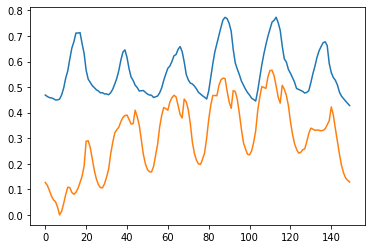

In [ ]:
n = 150
plt.plot( range(n), scaled['temperatura'][:n])
plt.plot( range(n), scaled['carga'][:n])

plt.show()

In [ ]:
scaled.head(50)

In [ ]:
# n_steps_in : Specify how much data we want to look back for prediction
# n_step_out : Specify how much multi-step data we want to forecast


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return array(X), array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 168, 24

# covert into input/output
X, y = split_sequences(scaled.iloc[:,2:].to_numpy(), n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

X.shape (37034, 168, 1)
y.shape (37034, 24)


In [ ]:
split_point = 35000
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

# verificar o shape:
#train_X.shape -> [n_datasets,n_steps_in,n_features]
#train_y.shape -> [n_datasets,n_steps_out]
#test_X.shape 
#test_y.shape 
#n_features = 

In [ ]:
n_features = train_X.shape[-1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, n_features)

(35000, 168, 1) (35000, 24) (2034, 168, 1) (2034, 24) 1


In [ ]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(45, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))

model.compile(loss='mse' , optimizer=opt , metrics=['mse'])

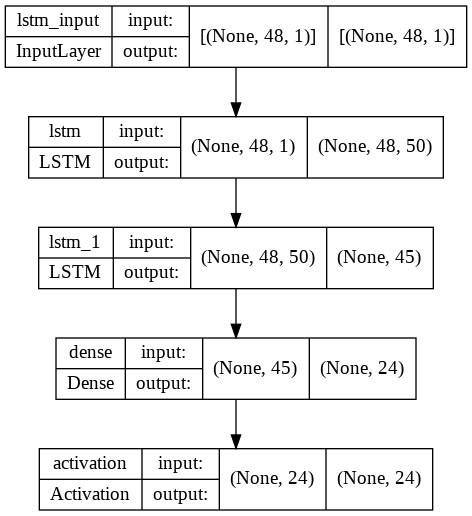

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit network
history = model.fit(train_X , train_y , epochs=50  , steps_per_epoch=50,verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)

Epoch 1/50
50/50 [==============================] - 66s 1s/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 2/50
50/50 [==============================] - 62s 1s/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 3/50
50/50 [==============================] - 63s 1s/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 4/50
50/50 [==============================] - 62s 1s/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 5/50
50/50 [==============================] - 62s 1s/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 6/50
50/50 [==============================] - 63s 1s/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 7/50
50/50 [==============================] - 62s 1s/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/50
50/50 [==============================] - 63s 1s/step - loss: 0.0220 - mse: 0.02

In [ ]:
y_hat = model.predict(test_X)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

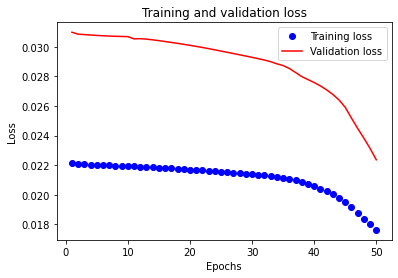

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import r2_score

score = r2_score(test_y, y_hat) #true, pred.
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.1986


In [ ]:
y_train_prev = model.predict(train_X)

In [ ]:
score = r2_score(train_y, y_train_prev) #true, pred.
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.189


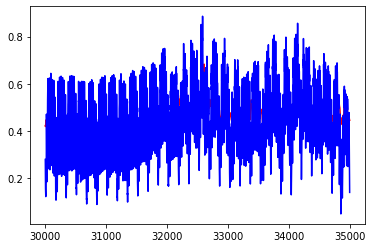

In [ ]:
plt.plot(DataFrame(y_train_prev).iloc[30000:35000,0],'r')
plt.plot(DataFrame(train_y).iloc[30000:35000,0],'b')

plt.show()

In [ ]:
score = []
for dia in range(14):
  score.append(r2_score(DataFrame(test_y).iloc[:,dia],DataFrame(y_hat).iloc[:,dia])) #true, pred.
  #print('R-squared score for the test set:', round(score,4))

print(score)

In [ ]:
plt.scatter(DataFrame(test_y).iloc[:,0],DataFrame(y_hat).iloc[:,0], edgecolors='b')

m, b = np.polyfit(DataFrame(test_y).iloc[:,0],DataFrame(y_hat).iloc[:,0], 1)
plt.plot(DataFrame(test_y).iloc[:,0], m*(DataFrame(test_y).iloc[:,0]) + b, color='red', linestyle='dashed')
plt.title('Dispersão')
plt.xlabel('Vazão Obs.')
plt.ylabel("Vazão Calc.");
plt.show()